In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPUs


In [2]:
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/sea_lions
oregon_wildlife/red_fox
oregon_wildlife/deer
oregon_wildlife/black_bear
oregon_wildlife/bald_eagle
oregon_wildlife/nutria
oregon_wildlife/virginia_opossum
oregon_wildlife/cougar
oregon_wildlife/raven
oregon_wildlife/raccoon

total img num: 7168


### Show Random Photos of Dataset

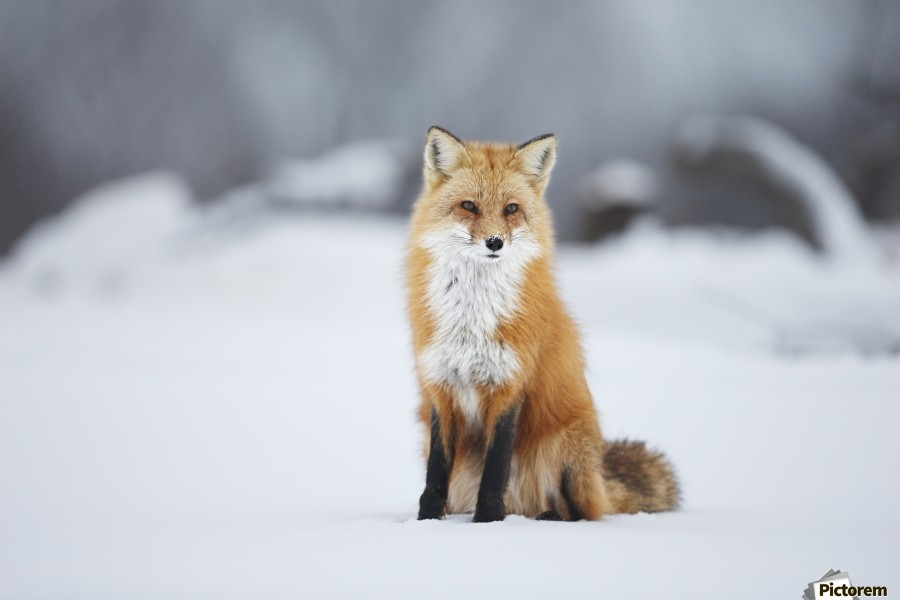

red_fox


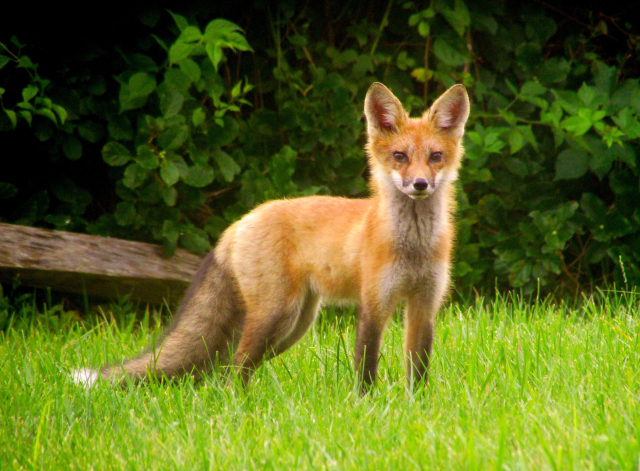

red_fox


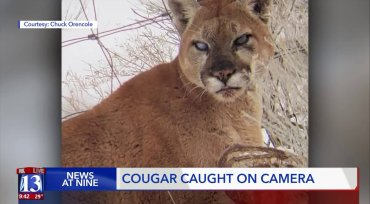

cougar


In [3]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

### Getting the labels

In [4]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
n_classes = len(label_names)
print(label_names)
print("Total number of calsses: %d" % n_classes)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']
Total number of calsses: 10


### Getting the mapping dictionary

In [5]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


### Getting label data

In [6]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [6, 4, 3, 4, 8, 3, 7, 8, 7, 8]


### Create training and  validation set

In [7]:
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


### Prepocessing parameter setting

In [8]:
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

BUFFER_SIZE = 10000
BATCH_SIZE = 32

### Loading image data function

In [9]:
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img, label

### Loading image as tf.dataset

In [10]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
dataset_train = dataset_train.map(load_image)

dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)

In [11]:
it = iter(dataset_train)

for i in range(1):
    print(next(it)[0].numpy().flatten().shape)


(270000,)


### Writing the tf.dataset into tf.record 

In [12]:
# See the structure of tf.dataset
dataset_train

<MapDataset shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int32)>

The dataset\[0\] is a 300\*300 image with RGB channels 

#### Creating functions for serialize the image and label.

The \_img\_feature is for serializing image data.

In [13]:
def _img_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.numpy().flatten()))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [14]:
def serialize_example(img, label):
    feature = {
        'img': _img_feature(img),
        'label': _int64_feature(label),
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [15]:
def tf_serialize_example(img,label):
    tf_string = tf.py_function(
        serialize_example,
        (img,label),
        tf.string)
    return tf.reshape(tf_string, ())

In [16]:
serialized_dataset_train = dataset_train.map(tf_serialize_example)
serialized_dataset_train

<MapDataset shapes: (), types: tf.string>

In [17]:
filename = 'train.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_dataset_train)

In [18]:
serialized_dataset_val = dataset_val.map(tf_serialize_example)
filename = 'valid.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_dataset_val)

### Reading from tfrecord (train.tfrecord)

In [19]:
filename = 'train.tfrecord'
raw_dataset_train = tf.data.TFRecordDataset(filename)
raw_dataset_train

<TFRecordDatasetV2 shapes: (), types: tf.string>

Since my code flatten the image data before serialization, the shape of \'img\' read from tfrecord need to be (270000,)

In [20]:
feature_description = {
    'img': tf.io.FixedLenFeature([270000], tf.float32),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    return parsed['img'], parsed['label']

#### Function to reshape image tensor

I need to reshape the image data, from (270000,) to (300,300,3)

In [21]:
def reshape_func(img, label):
    img = tf.reshape(img,[300,300,3])
    
    return img, label
    

In [22]:
parsed_dataset_train = raw_dataset_train.map(_parse_function)
parsed_dataset_train

<MapDataset shapes: ((270000,), ()), types: (tf.float32, tf.int64)>

In [23]:
for parsed_record in parsed_dataset_train.take(3):
    print(parsed_record[0])

tf.Tensor([0.5019608  0.6509804  0.654902   ... 0.5180195  0.64743125 0.7062548 ], shape=(270000,), dtype=float32)
tf.Tensor([0.50980395 0.56078434 0.58431375 ... 0.4099346  0.26875815 0.20601304], shape=(270000,), dtype=float32)
tf.Tensor([0.29803923 0.50980395 0.17843138 ... 0.18039216 0.30588236 0.09019608], shape=(270000,), dtype=float32)


In [24]:
parsed_dataset_train = parsed_dataset_train.map(reshape_func)
for parsed_record in parsed_dataset_train.take(3):
    print(parsed_record[0])

tf.Tensor(
[[[0.5019608  0.6509804  0.654902  ]
  [0.5008431  0.6498627  0.6537843 ]
  [0.49803922 0.64705884 0.6509804 ]
  ...
  [0.2177452  0.24127461 0.20205893]
  [0.21960784 0.24313726 0.20392157]
  [0.23025525 0.24313726 0.2074707 ]]

 [[0.51460785 0.66362745 0.67260784]
  [0.5134902  0.6625098  0.6714902 ]
  [0.5106863  0.6597059  0.6686863 ]
  ...
  [0.22413202 0.25006425 0.20964716]
  [0.22719608 0.2507255  0.21150981]
  [0.2332651  0.25301468 0.21505894]]

 [[0.53117645 0.67859477 0.698366  ]
  [0.5300588  0.6774771  0.69724834]
  [0.5272549  0.6746732  0.6944444 ]
  ...
  [0.23076972 0.25970587 0.21778683]
  [0.23411883 0.26085085 0.22003387]
  [0.2381243  0.26195785 0.2225901 ]]

 ...

 [[0.65312564 0.6923413  0.7148248 ]
  [0.6556925  0.69490826 0.71739167]
  [0.6589156  0.7014376  0.722819  ]
  ...
  [0.53277224 0.6654902  0.72321165]
  [0.5325568  0.6619685  0.72079206]
  [0.5318955  0.65985805 0.71868163]]

 [[0.6789411  0.72094107 0.7631959 ]
  [0.6800587  0.7220587  0

(300, 300, 3)
sea_lions


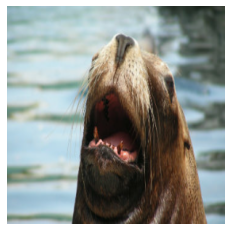

(300, 300, 3)
virginia_opossum


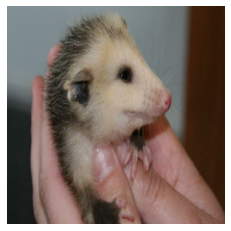

(300, 300, 3)
raccoon


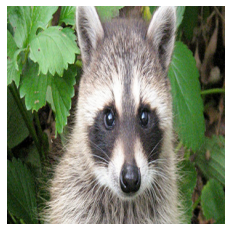

(300, 300, 3)
black_bear


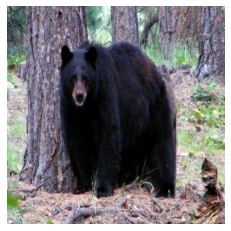

(300, 300, 3)
raccoon


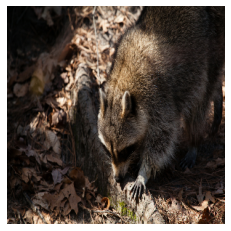

In [25]:
for parsed_record in parsed_dataset_train.take(5):
    print(parsed_record[0].shape)
    print(index_to_label[parsed_record[1].numpy()])
    plt.imshow(parsed_record[0]) 
    plt.axis('off') 
    plt.show()

### Reading from tfrecord (valid.tfrecord)

(300, 300, 3)
black_bear


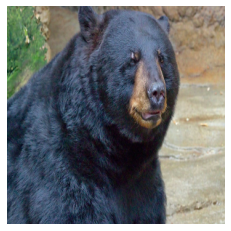

(300, 300, 3)
black_bear


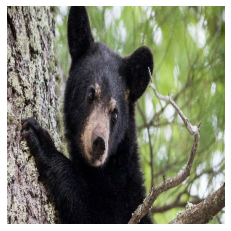

(300, 300, 3)
raven


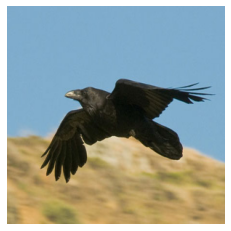

In [26]:
filename = 'valid.tfrecord'
raw_dataset_val = tf.data.TFRecordDataset(filename)
raw_dataset_val
parsed_dataset_val = raw_dataset_val.map(_parse_function)
parsed_dataset_val = parsed_dataset_val.map(reshape_func)
for parsed_record in parsed_dataset_val.take(3):
    print(parsed_record[0].shape)
    print(index_to_label[parsed_record[1].numpy()])
    plt.imshow(parsed_record[0]) 
    plt.axis('off') 
    plt.show()

### Preprocessing the dataset

In [27]:
def map_fun(img,label):
    distorted_img = tf.image.random_crop(img, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_img = tf.image.random_flip_left_right(distorted_img)
    distorted_img = tf.image.random_brightness(distorted_img, max_delta=63)
    distorted_img = tf.image.random_contrast(
        distorted_img, lower=0.2, upper=1.8)
    distorted_img = tf.image.per_image_standardization(distorted_img)
    
    return distorted_img, label

def map_fun_val(img,label):
    distorted_img = tf.image.resize_with_crop_or_pad(img, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_img = tf.image.per_image_standardization(distorted_img)
    
    return distorted_img, label

In [28]:
dataset_train = parsed_dataset_train.map(map_fun)
dataset_train = dataset_train.shuffle(1000)
dataset_train = dataset_train.batch(64)

dataset_val = parsed_dataset_val.map(map_fun_val)
dataset_val = dataset_val.batch(64)

#### Show some picture after preprocessing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


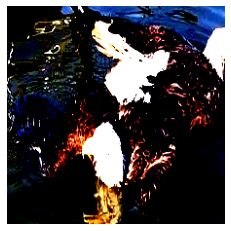

bald_eagle


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


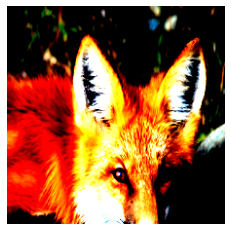

red_fox


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


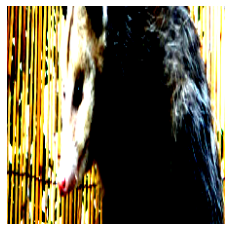

virginia_opossum


In [29]:
for img, label in dataset_train.take(3):
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

### Train the model 

In [30]:
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [31]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [32]:
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(dataset_train, validation_data=dataset_val, epochs=5)

Epoch 1/5
90/90 [==============================] - 425s 5s/step - loss: 3.5633 - accuracy: 0.5208 - val_loss: 0.3729 - val_accuracy: 0.8856
Epoch 2/5
90/90 [==============================] - 11s 126ms/step - loss: 0.5949 - accuracy: 0.8003 - val_loss: 0.3482 - val_accuracy: 0.8856
Epoch 3/5
90/90 [==============================] - 11s 127ms/step - loss: 0.4722 - accuracy: 0.8427 - val_loss: 0.2433 - val_accuracy: 0.9282
Epoch 4/5
90/90 [==============================] - 11s 127ms/step - loss: 0.4579 - accuracy: 0.8516 - val_loss: 0.2141 - val_accuracy: 0.9365
Epoch 5/5
90/90 [==============================] - 11s 128ms/step - loss: 0.3871 - accuracy: 0.8776 - val_loss: 0.1699 - val_accuracy: 0.9463
